In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
# Read input video

def movingAverage(curve, radius):
    window_size = 2 * radius + 1
  # Define the filter
    f = np.ones(window_size)/window_size
    # Add padding to the boundaries
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge')
  # Apply convolution
    curve_smoothed = np.convolve(curve_pad, f, mode='same')
  # Remove padding
    curve_smoothed = curve_smoothed[radius:-radius]
  # return smoothed curve
    return curve_smoothed

def smooth(trajectory, SMOOTHING_RADIUS = 50):
    
    smoothed_trajectory = np.copy(trajectory)
    # Filter the x, y and angle curves
    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=SMOOTHING_RADIUS)
    return smoothed_trajectory

def fixBorder(frame):
    s = frame.shape
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)

    frame = cv2.warpAffine(frame, T, (s[1], s[0]))

    return frame
    
path = "depositphotos_358277576-stock-video-tanks-military-armored-vehicles-in.mp4"
new_path = path.split('/')[-1]
print(path.replace(".mp4", "-stabilized.mp4"))
cap = cv2.VideoCapture(path)

n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

 

# Get width and height of video stream

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ret, prev = cap.read()
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

transforms = np.zeros((n_frames-1, 3), np.float32)
for i in range(n_frames-2):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)

    ret, curr = cap.read()
    if not ret:
        break
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)

    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]
    m = cv2.estimateAffine2D(prev_pts, curr_pts)
    # print(m)
    m = m[0]
    dx = m[0,2]
    dy = m[1,2]
    da = np.arctan2(m[1,0], m[0,0])
    transforms[i] = [dx,dy,da]
    prev_gray = curr_gray

trajectory = np.cumsum(transforms, axis=0)
plt.rcParams["figure.figsize"] = (20,10)

smoothed_trajectory = smooth(trajectory, 50)
difference = smoothed_trajectory - trajectory
transforms_smooth = transforms + difference


to_write = False

if to_write:
    writer = cv2.VideoWriter(path.replace(".mp4", "-stabilized.mp4"), cv2.VideoWriter_fourcc(*"mp4v"), 30., (w, h))
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
matrices = []
for i in range(n_frames-2):
    success, frame = cap.read()
    if not success:
        break
    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]
    matrices.append([float(dx), float(dy), float(da)])
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy
    A = m[:2, :2]
    A_int = np.linalg.inv(A)
    B = m[:, 2]
#     print(B)
#     print(A)
#     print(m)
    
    #break
    frame_stabilized = cv2.warpAffine(frame, m, (w,h))
#     frame_stabilized = fixBorder(frame_stabilized)
#     bbox = cv2.selectROI("Frame 1", frame_stabilized)
#     bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
#     print(bbox)
    if to_write:
        writer.write(frame_stabilized)

# import json
# with open(f"matrices/{new_path[:new_path.find('.mp4')]}.json" , 'w') as f:
# 	json.dump(matrices, f)
# if to_write:
#     writer.release()



depositphotos_358277576-stock-video-tanks-military-armored-vehicles-in-stabilized.mp4


In [2]:
transforms

array([[ 6.9044938e+00, -1.4085107e+00,  5.7646789e-04],
       [ 4.6597233e+00, -1.8959713e+00,  6.7130121e-04],
       [ 5.0802526e+00, -1.8756865e+00,  2.6078924e-04],
       ...,
       [-3.8077688e-01, -2.6359761e-01,  1.3808176e-03],
       [-2.9953924e-01, -3.0605236e-01,  1.0300669e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

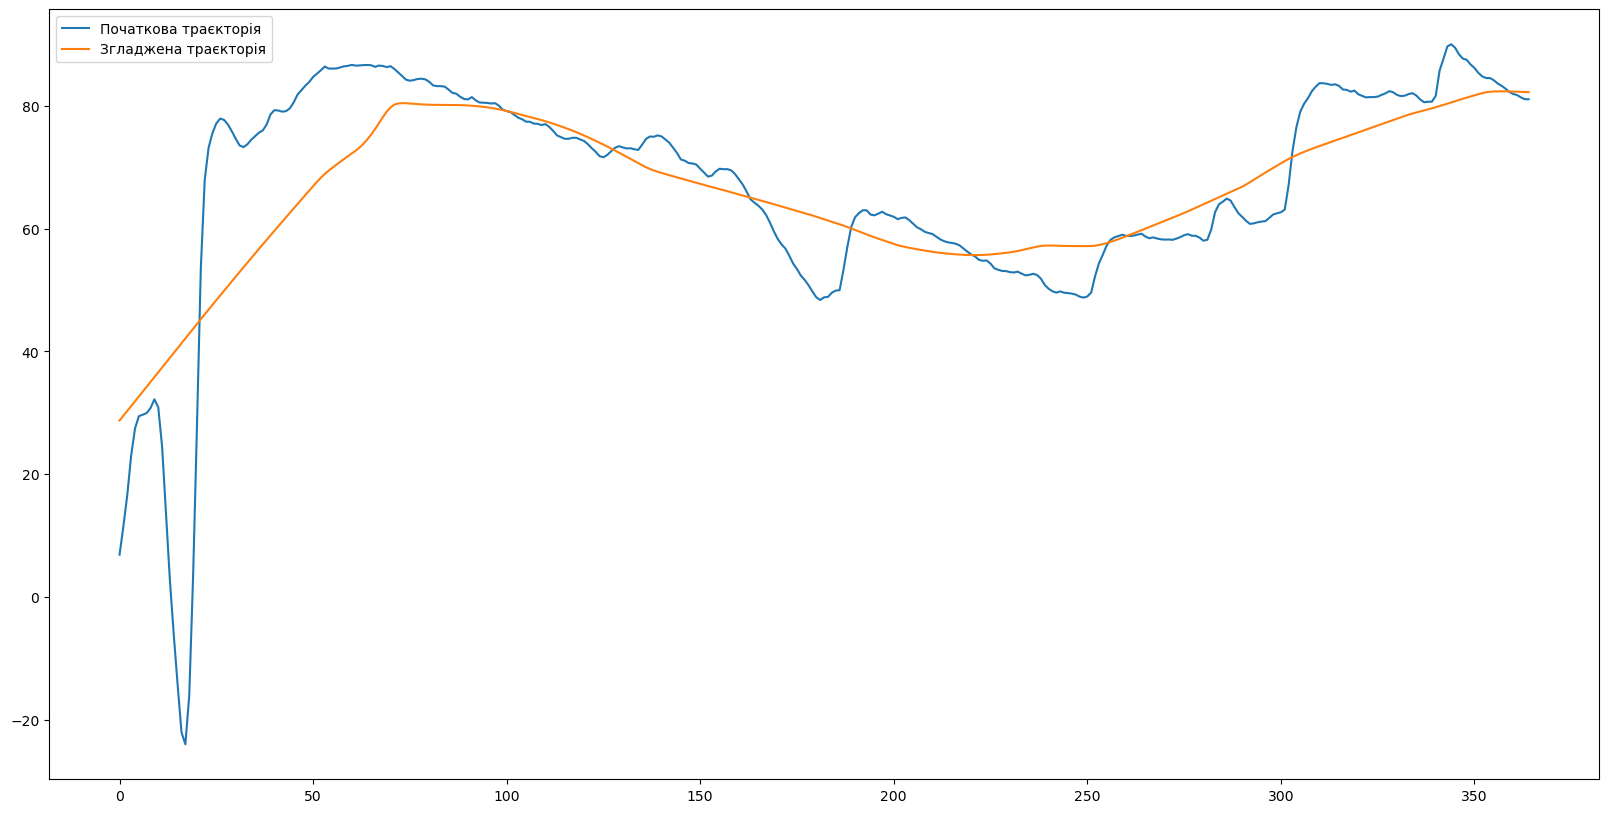

In [9]:
plt.plot(trajectory[:,0], label="Початкова траєкторія")
plt.plot(smoothed_trajectory[:,0], label='Згладжена траєкторія')
plt.legend()
plt.show()

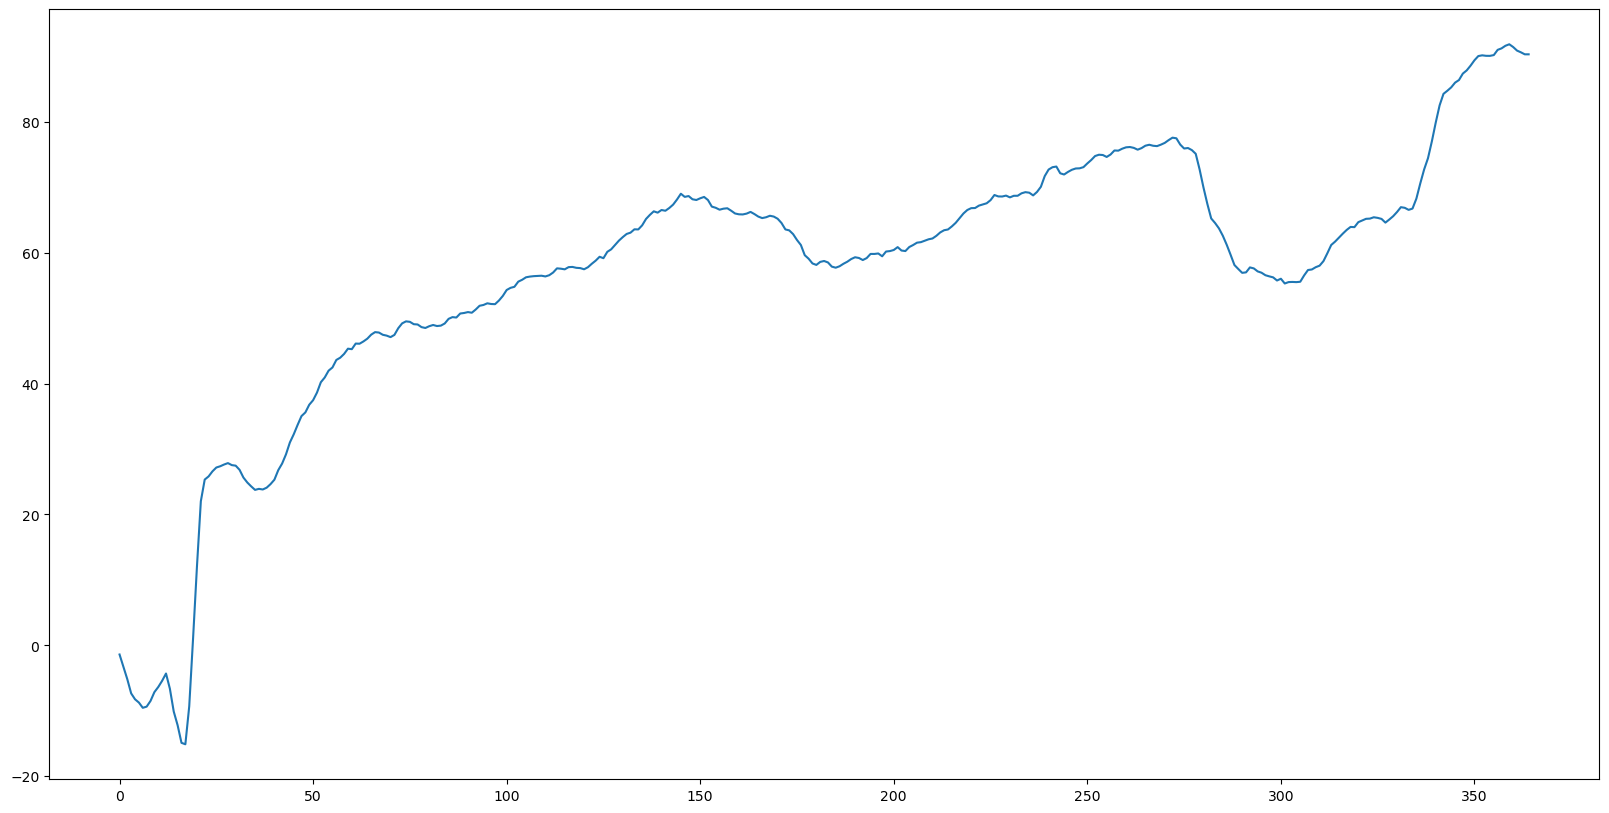

In [4]:
plt.plot(trajectory[:,1])
plt.show()

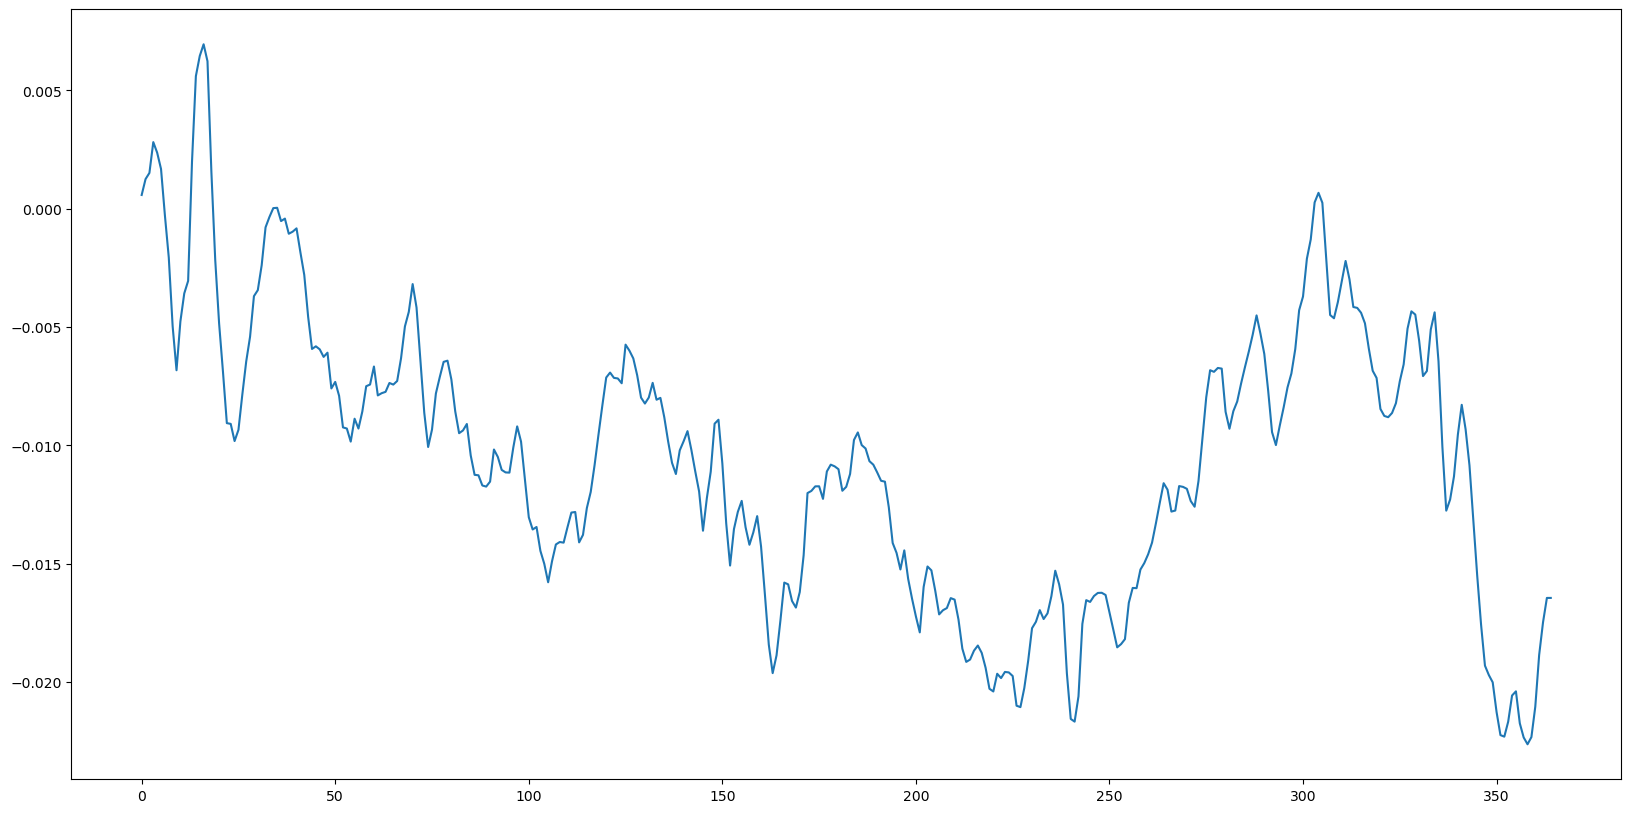

In [5]:
plt.plot(trajectory[:,2])
plt.show()